In [12]:
from pyfmi import load_fmu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [16,9]

In [1]:
def create_schedule(initial_setpoint=20, action=[-0.5, 0, 0.5], T=3):
    sequences = [[initial_setpoint]]
    t = 0
    possible_sequence = []
    while t < T:
        for sequence in sequences:
            for n in range(len(action)):
                new_sequence = sequence + [sequence[-1] + action[n]]
                possible_sequence.append(new_sequence)
        sequences = possible_sequence
        possible_sequence = []
        t += 1
    sequences = [item[1:] for item in sequences]
    return sequences

def simulate(start, stop, secondperstep, heat_setpoint_schedule, cool_setpoint_schedule):
    model = 'newyork.fmu'
    model = load_fmu(model)
    opts = model.simulate_options()
    opts['ncp'] = num_sim_steps
    opts['initialize'] = False
    
    model.initialize(start, stop)
    index = 0
    simtime = start
    num_steps = (stop - start)//secondperstep
    temp = np.zeros((num_steps, ))
    ppd = np.zeros((num_steps, ))
    while simtime < stop:
        model.set('Heatsetpoint', heat_setpoint_schedule[index])
        model.set('Coolsetpoint', cool_setpoint_schedule[index])
        model.do_step(simtime, secondperstep, True)

        temp[index] = model.get('Ttop')
        ppd[index] = model.get('ppdTop')
        simtime += secondperstep
        index += 1
    model.terminate()
    model.reset()
    return temp, ppd

def calculate_reward(temp_hat, temp_target):
    return np.square(temp_hat - temp_target).sum()

def calculate_ppd_reward(ppd_hat, ppd_target):
    return np.square(ppd_hat - ppd_target).sum()

def get_action_index(reward):
    
    rank = {}
    temp_reward = reward[:, 0]
    temp_reward_sort_idx = np.argsort(temp_reward)
    ppd_reward = reward[:, 1]
    ppd_reward_sort_idx = np.argsort(ppd_reward)
    
    for i in range(reward.shape[0]):
        rank[i] = 0.8 * np.where(temp_reward_sort_idx == i)[0][0]
        rank[i] += 0.2 * np.where(ppd_reward_sort_idx == i)[0][0]
        
    index = min(rank, key=rank.get)
    return index

In [2]:
total_days = 1
days = 1
hours = 24
minutes = 60
seconds = 60
timestep = 3
num_sim_steps = days*hours*timestep
timestop = days*hours*minutes*seconds
secondperstep = timestop//num_sim_steps


T = 2
action = [-0.5, 0, 0.5]
num_action = len(action)
temp_target = 24
ppd_target = 5
num_total_steps = total_days*hours*timestep
# print(num_total_steps)

heat_schedule_total = np.zeros((num_total_steps, ))
cool_schedule_total = np.zeros((num_total_steps, ))
saved_temp = np.zeros((num_total_steps, ))
saved_ppd = np.zeros((num_total_steps, ))

current_step = 0
current_time = 0
heat_setpoint = 20
cool_setpoint = 30

end = total_days*hours*minutes*seconds

while current_time < end:
    
    start = max(current_time // (timestop//2) * (timestop//2) - timestop//2, 0)
    stop = start + timestop
    
    if current_time % (timestop//2) + T*secondperstep <= (timestop//2):

        heat_schedules = create_schedule(heat_setpoint, action, T)
        cool_schedules = create_schedule(cool_setpoint, action, T)
        rewards = []
        temps = []
        ppds = []
        
        sch_idx = max(current_step // (num_sim_steps//2) * (num_sim_steps//2) - num_sim_steps//2, 0)
        index = current_step - sch_idx
        
        for i in range(len(heat_schedules)):
            
            heat_schedule = heat_schedule_total[sch_idx:sch_idx+num_sim_steps].copy()
            heat_schedule[index:index+T] = np.array(heat_schedules[i])
            
            cool_schedule = cool_schedule_total[sch_idx:sch_idx+num_sim_steps].copy()
            cool_schedule[index:index+T] = np.array(cool_schedules[i])

            Tcore, ppd_core = simulate(start, stop, secondperstep, heat_schedule, cool_schedule)

            temp = Tcore[index:index+T]
            print(temp)
            ppd = ppd_core[index:index+T]
            reward_temp = calculate_reward(temp, temp_target)
            reward_ppd = calculate_ppd_reward(ppd, ppd_target)

            temps.append(temp)
            ppds.append(ppd)
            rewards.append([reward_temp,  reward_ppd])

        rewards = np.array(rewards)
        index = get_action_index(rewards)
        
        heat_setpoint = heat_schedules[index][0]
        cool_setpoint = cool_schedules[index][0]
        print(heat_setpoint)
        print(rewards)
    heat_schedule_total[current_step] = heat_setpoint
    cool_schedule_total[current_step] = cool_setpoint
    saved_temp[current_step] = temps[index][0]
    saved_ppd[current_step] = ppds[index][0]
    print("saved:", temps[index][0])
    
    
    current_step += 1
    current_time += secondperstep
    
    print('itr:', current_step)
    print("===================")


[16.67881499 16.89093552]
[16.67881499 16.89093572]
[16.67881499 16.89093346]
[16.67278687 16.92099808]
[16.67278687 16.92100612]
[16.67278687 16.92156921]
[16.67881499 16.89093273]
[16.67881499 16.8909343 ]
[16.67881499 16.89093402]
20
[[ 104.13854775 7628.65333483]
 [ 104.13854492 7628.65333483]
 [ 104.13857708 7628.65333483]
 [ 103.80032053 7642.48023336]
 [ 103.8002066  7642.48023336]
 [ 103.79223471 7642.48023336]
 [ 104.13858746 7628.65333483]
 [ 104.13856506 7628.65333483]
 [ 104.13856908 7628.65333483]]
saved: 16.67278686562175
itr: 1
[16.92099808 16.09931953]
[16.92099808 16.09931953]
[16.92099808 16.09931953]
[16.92100612 16.0993234 ]
[16.92100612 16.0993234 ]
[16.92100612 16.0993234 ]
[16.92156921 16.09959165]
[16.92156921 16.09959165]
[16.92156921 16.09959165]
20.5
[[ 112.53302015 6659.06437738]
 [ 112.53302015 6659.06437738]
 [ 112.53302015 6659.06437738]
 [ 112.53284499 6659.05652477]
 [ 112.53284499 6659.05652477]
 [ 112.53284499 6659.05652477]
 [ 112.52063445 6658.54004

[16.88629144 17.76767148]
18.5
[[  93.77079249 5267.86262275]
 [  90.12985929 5267.86262275]
 [  89.47810238 5267.86262275]
 [  90.07345387 5267.86262275]
 [  89.36430795 5267.86262275]
 [  89.36385366 5267.86262275]
 [  89.40928906 5267.86262275]
 [  89.40893706 5267.86262275]
 [  89.44676823 5267.86262275]]
saved: 16.88629144273397
itr: 15
[17.71759565 17.49666173]
[17.71759565 17.7615643 ]
[17.71759565 17.76018332]
[17.77429052 17.7967219 ]
[17.77429052 17.79492645]
[17.77429052 17.7945611 ]
[17.77432701 17.79501478]
[17.77432701 17.79465344]
[17.77432701 17.79465499]
18.5
[[  81.76201315 5227.7094235 ]
 [  78.38668436 5227.7094235 ]
 [  78.40391659 5227.7094235 ]
 [  77.24011766 5154.56062083]
 [  77.26239624 5154.56062083]
 [  77.26693044 5154.56062083]
 [  77.26084583 5154.46952583]
 [  77.26533013 5154.46952583]
 [  77.26531092 5154.46952583]]
saved: 17.7742905215102
itr: 16
[17.7967219  16.97982164]
[17.7967219  16.97982164]
[17.7967219  16.97982164]
[17.79492645 16.97989829]
[

[17.72577981 18.58334576]
[17.72577981 18.58373805]
[17.72577981 18.58401472]
[17.72577981 18.58381516]
[17.72577981 18.58402554]
[17.72577981 18.58400732]
[17.72577981 18.58386423]
[17.72577981 18.58385958]
[17.72577981 18.58385732]
20.5
[[  68.70598215 3325.07178672]
 [  68.70173246 3325.07178672]
 [  68.69873551 3325.07178672]
 [  68.7008972  3325.07178672]
 [  68.69861835 3325.07178672]
 [  68.69881562 3325.07178672]
 [  68.70036565 3325.07178672]
 [  68.70041596 3325.07178672]
 [  68.70044052 3325.07178672]]
saved: 17.72577981227187
itr: 30
[18.58381516 18.68776981]
[18.58381516 18.68057866]
[18.58381516 18.68026317]
[18.58402554 18.70911919]
[18.58402554 18.68783557]
[18.58402554 18.68035687]
[18.58400732 18.68075233]
[18.58400732 18.68034789]
[18.58400732 18.68035141]
20.5
[[  57.55484785 3175.65436937]
 [  57.63130162 3175.65436937]
 [  57.63465822 3175.65436937]
 [  57.32619909 3175.30197272]
 [  57.55187034 3175.30197272]
 [  57.63138246 3175.30197272]
 [  57.62737244 3175.31

[18.75185713 19.49931545]
[18.75185713 19.49931572]
[18.75185713 19.49829099]
21.0
[[  47.66355353 1693.68289441]
 [  47.69107381 1693.68289441]
 [  47.68968441 1693.68289441]
 [  47.66068931 1693.68289441]
 [  47.65912955 1693.68289441]
 [  47.65914581 1693.68289441]
 [  47.79916506 1693.68289441]
 [  47.79916265 1693.68289441]
 [  47.80838767 1693.68289441]]
saved: 18.75185712671281
itr: 45
[19.51472568 19.54819455]
[19.51472568 19.54782793]
[19.51472568 19.5477043 ]
[19.51489956 19.72591226]
[19.51489956 19.54822171]
[19.51489956 19.54791136]
[19.51489775 19.54822114]
[19.51489775 19.54791078]
[19.51489775 19.54791078]
21.0
[[  39.93625747 1651.409694  ]
 [  39.93952188 1651.409694  ]
 [  39.9406227  1651.409694  ]
 [  38.38395197 1651.19929897]
 [  39.93445584 1651.19929897]
 [  39.9372192  1651.19929897]
 [  39.93447725 1651.19996911]
 [  39.93724057 1651.19996911]
 [  39.93724062 1651.19996911]]
saved: 19.5148995626999
itr: 46
[19.72591226 18.90784266]
[19.72591226 18.90784266]
[

[18.83425563 18.99936466]
[18.83425563 19.39991881]
[18.83425563 19.5917512 ]
[18.83425563 19.39992859]
[18.83425563 19.59176218]
[18.83425563 19.59176081]
[18.83425563 19.58737065]
[18.83425563 19.58737113]
[18.83425563 19.58364536]
20.0
[[  51.69126874 1606.84217403]
 [  47.84566185 1606.84217403]
 [  46.11757238 1606.84217403]
 [  47.84557187 1606.84217403]
 [  46.11747559 1606.84217403]
 [  46.11748763 1606.84217403]
 [  46.15621269 1606.84217403]
 [  46.15620844 1606.84217403]
 [  46.18910317 1606.84217403]]
saved: 18.83425563137676
itr: 60
[19.39992859 19.00224059]
[19.39992859 19.4643499 ]
[19.39992859 19.47650295]
[19.59176218 19.50059173]
[19.59176218 19.56330279]
[19.59176218 19.57312083]
[19.59176081 19.56330212]
[19.59176081 19.56330212]
[19.59176081 19.56330212]
20.0
[[  46.13825614 1689.74834965]
 [  41.73277886 1689.74834965]
 [  41.62268251 1689.74834965]
 [  39.67723547 1596.78801283]
 [  39.11684282 1596.78801283]
 [  39.02981993 1596.78801283]
 [  39.11686081 1596.78

In [17]:
out = pd.DataFrame(index=pd.date_range(start='2017-1-1', freq='20MIN', periods=72), 
             data={
                 'heat setpoint': heat_schedule_total,
                 'cool setpoint': cool_schedule_total,
                 'temperature': saved_temp,
                 'ppd': saved_ppd
             })

<AxesSubplot:>

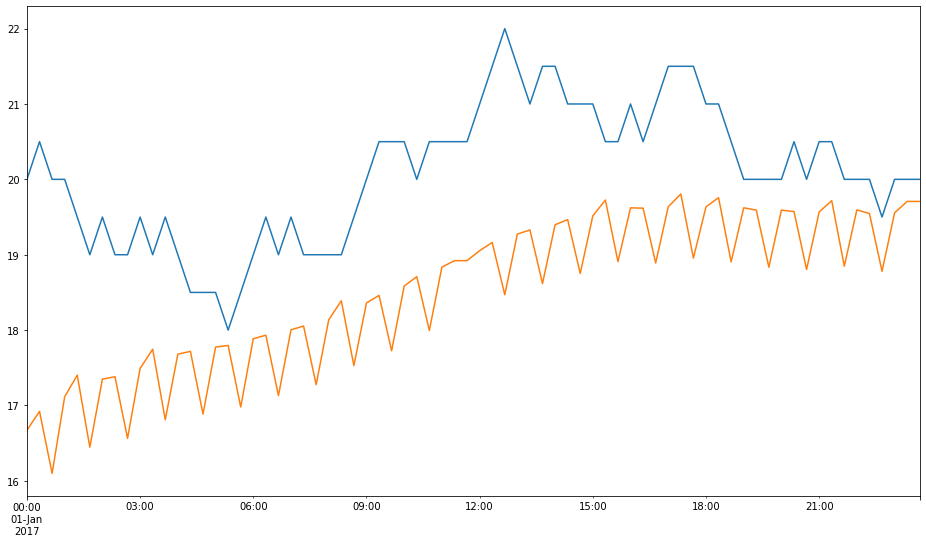

In [19]:
fig,ax = plt.subplots()
out['heat setpoint'].plot(ax=ax)
out['temperature'].plot(ax=ax)